In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

### Set the configurations.

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

### Load the raw CIFAR-10 data.

In [3]:
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
    del X_train, y_train
    del X_test, y_test
    print('Clear previously loaded data.')
except:
    pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


### Visualize the CIFAR-10 data.

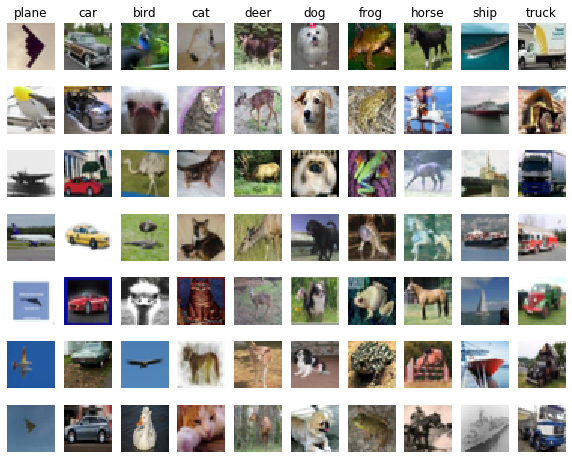

In [4]:
# Visualize some examples from the dataset.
# Show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

### Split the data into train, val, and test sets.

In [5]:
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Validation set will be num_validation points from the original training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Training set will be the first num_train points from the original training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# Make a development set, which is a small subset of the training set.
# Used for development so our code runs faster.
# Used for testing the model trained from the training set, optimizing the model from the results.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# Use the first num_test points of the original test set as our test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


### Data preprocessing: reshape and subtract the mean

In [6]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


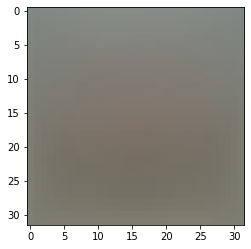

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [7]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
# constant 1 is the default bias dimension
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

### Implement the SVM classifier.

#### svm_loss_naive

In [8]:
# Evaluate the naive implementation of the loss.
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)
print('loss: %f' % (loss, ))

loss: 8.902424


In [9]:
# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0] # (f = lambda x:y) returns the results of function in f
                                                      # lambda x means the function recieves the parameter x
                                                      # y means what is the output of the function
                                                      # The function receive the x parameter, then do the y thing,
                                                      # then store the output in f.
                                                      # same as function(x):
                                                      #             y
                                                      #             return y
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 41.609078 analytic: 41.609078, relative error: 3.217237e-12
numerical: -13.135791 analytic: -13.135791, relative error: 3.207872e-11
numerical: -5.522878 analytic: -5.522878, relative error: 4.850127e-11
numerical: -4.868233 analytic: -4.868233, relative error: 3.559805e-11
numerical: -13.501764 analytic: -13.501764, relative error: 8.361074e-12
numerical: 19.616657 analytic: 19.616657, relative error: 6.642280e-12
numerical: -25.918725 analytic: -25.918725, relative error: 1.083275e-12
numerical: 24.039400 analytic: 24.039400, relative error: 1.380686e-11
numerical: 1.453459 analytic: 1.453459, relative error: 1.322383e-11
numerical: 30.817127 analytic: 30.817127, relative error: 8.266651e-12
numerical: 10.929603 analytic: 10.929603, relative error: 2.941887e-11
numerical: -39.813100 analytic: -39.813100, relative error: 1.016063e-11
numerical: -11.409726 analytic: -11.409726, relative error: 9.930789e-12
numerical: -42.564822 analytic: -42.564822, relative error: 8.097033e

#### svm_loss_vectorized

In [10]:
from cs231n.classifiers.linear_svm import svm_loss_vectorized

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.

tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))
print('Naive loss: %e' % loss_naive)

tic = time.time()
loss_vectorized, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))
print('Vectorized loss: %e' % loss_vectorized)

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro') # numpy.linalg.norm(array, ord)
                                                                     # ord means order of the norm, 'fro' = Frobenius norm
print('loss difference: %f' % (loss_naive - loss_vectorized))
print('gradient difference: %f' % difference)

Naive loss and gradient: computed in 0.082780s
Naive loss: 8.902424e+00
Vectorized loss and gradient: computed in 0.005300s
Vectorized loss: 8.902424e+00
loss difference: 0.000000
gradient difference: 0.000000


### Stochastic Gradient Descent (SGD)

In [11]:
from cs231n.classifiers import LinearSVM

svm = LinearSVM()

tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 793.891503
iteration 100 / 1500: loss 289.096667
iteration 200 / 1500: loss 109.051002
iteration 300 / 1500: loss 42.969662
iteration 400 / 1500: loss 18.729625
iteration 500 / 1500: loss 10.008871
iteration 600 / 1500: loss 6.852391
iteration 700 / 1500: loss 5.985497
iteration 800 / 1500: loss 5.927405
iteration 900 / 1500: loss 5.176436
iteration 1000 / 1500: loss 5.698795
iteration 1100 / 1500: loss 5.524502
iteration 1200 / 1500: loss 5.523820
iteration 1300 / 1500: loss 5.344513
iteration 1400 / 1500: loss 5.312068
That took 5.872601s


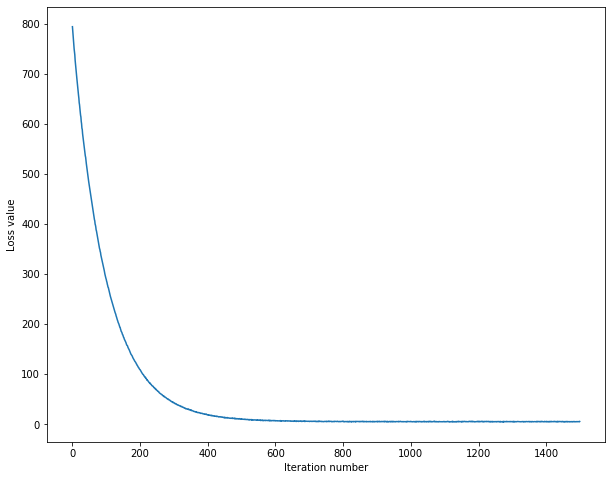

In [12]:
# A useful debugging strategy is to plot the loss as a function of iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [13]:
# Evaluate the performance on both the training and validation set.
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.368592
validation accuracy: 0.380000


In [14]:
# Use the validation set to tune hyperparameters (regularization strength and learning rate).

# (Note: you may see runtime/overflow warnings during hyper-parameter search. 
# This may be caused by extreme values, and is not a bug.)

learning_rates = [7e-8, 8e-8, 9e-8, 1e-7, 2e-7]
regularization_strengths = [1.5e4, 1.8e4, 2e4, 2.2e4, 2.5e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

svm = LinearSVM()

for lr in learning_rates:
    for reg in regularization_strengths:
        loss_hist = svm.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=1500, verbose=False)
        
        y_train_pred = svm.predict(X_train)
        y_train_acc = np.mean(y_train == y_train_pred)
        
        y_val_pred = svm.predict(X_val)
        y_val_acc = np.mean(y_val == y_val_pred)
        
        results[(lr, reg)] = (y_train_acc, y_val_acc)
        
        if y_val_acc > best_val:
            best_val = y_val_acc
            best_svm = svm

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 7.000000e-08 reg 1.500000e+04 train accuracy: 0.378959 val accuracy: 0.391000
lr 7.000000e-08 reg 1.800000e+04 train accuracy: 0.381490 val accuracy: 0.386000
lr 7.000000e-08 reg 2.000000e+04 train accuracy: 0.375184 val accuracy: 0.381000
lr 7.000000e-08 reg 2.200000e+04 train accuracy: 0.375367 val accuracy: 0.385000
lr 7.000000e-08 reg 2.500000e+04 train accuracy: 0.371286 val accuracy: 0.382000
lr 8.000000e-08 reg 1.500000e+04 train accuracy: 0.379449 val accuracy: 0.386000
lr 8.000000e-08 reg 1.800000e+04 train accuracy: 0.375755 val accuracy: 0.392000
lr 8.000000e-08 reg 2.000000e+04 train accuracy: 0.375878 val accuracy: 0.369000
lr 8.000000e-08 reg 2.200000e+04 train accuracy: 0.375347 val accuracy: 0.397000
lr 8.000000e-08 reg 2.500000e+04 train accuracy: 0.369714 val accuracy: 0.375000
lr 9.000000e-08 reg 1.500000e+04 train accuracy: 0.375714 val accuracy: 0.362000
lr 9.000000e-08 reg 1.800000e+04 train accuracy: 0.376388 val accuracy: 0.389000
lr 9.000000e-08 reg 2.000000

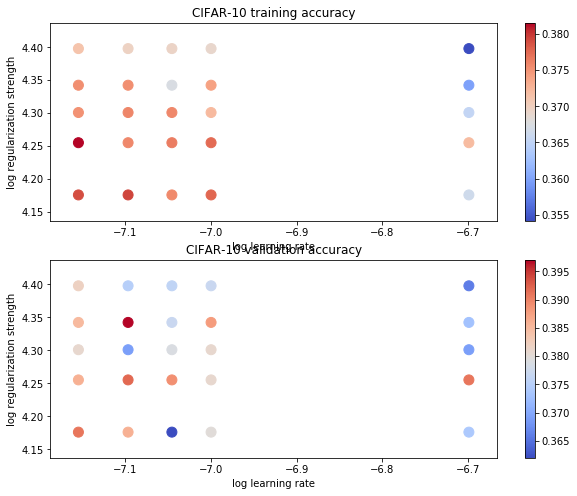

In [15]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [16]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.357000


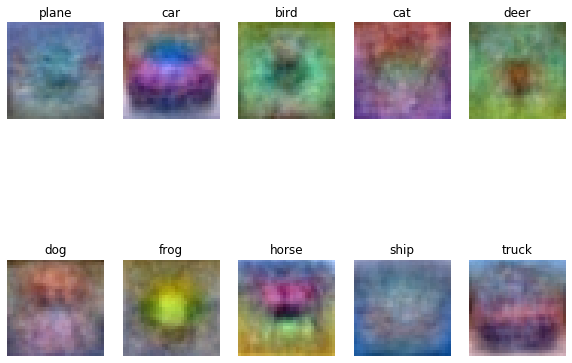

In [17]:
# Visualize the learned weights for each class.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min) # squeeze(): remove single-dimensional(1-D) 
                                                                       # entries from the shape of an array
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])